In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
# Setting the path for the dataset
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)

# Loading the prepared data
to = load_pickle(path/'to.pkl')

# Tabular Modelling Deep Dive

## Decision Trees
A decision tree asks a series of binary (yes/no) questions about the data. After eah question, the data at that part of the tree is split between a "yes" and a "no" branch. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.

This sequence of questions is now a procedure for taking any data item, whether an item from the training set or a new one, and assigning that item to a group. Namely, after asking and answering the questions, we can say the item belongs to the same group as all the other training data items that yielded the same set of answers to the questions. But what good is this? The goal of our model is to predict values for items, not to assign them into groups from the training dataset. The value is that we can now assign a prediction value for each of these groups—for regression, we take the target mean of the items in the group.

Let's consider how we find the right questions to ask. Of course, we wouldn't want to have to create all these questions ourselves—that's what computers are for! The basic steps to train a decision tree can be written down very easily:

1. Loop through each column of the dataset in turn.
2. For each column, loop through each possible level of that column in turn.
3. Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
4. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
5. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
6. We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
7. Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.

Although this is an easy enough algorithm to implement yourself (and it is a good exercise to do so), we can save some time by using the implementation built into sklearn.

## Creating our Decision Tree
To begin, we define our independent and dependent variables:

In [5]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

Now that our data is all numeric, and there are no missing values, we can create our decision tree.

In [8]:
model = DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(xs, y);

To keep it simple, we've told sklearn to just create four *leaf* nodes. To see what it's learned, we can display the tree:

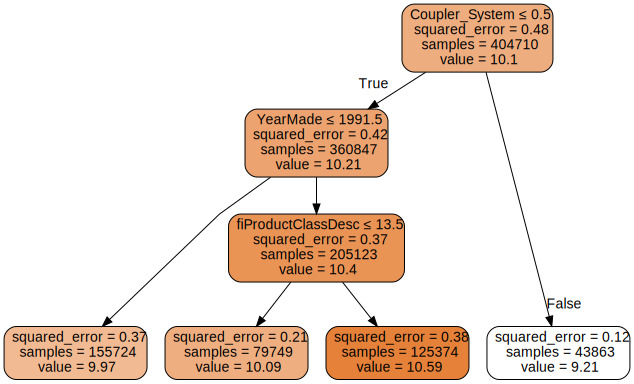

In [9]:
draw_tree(model, xs, size=10, leaves_parallel=True, precision=2)

Understanding this picture is one of the best ways to understand decision trees, so we will start at the top and explain each part step by step.

The top node represents the *initial model* before any splits have been done, when all the data is in one group. This is the simplest possible model. It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset. In this case, we can see it predicts a value of 10.10 for the logarithm of the sales price. It gives a mean squared error of 0.48. The square root of this is 0.69. (Remember that unless you see `m_rmse`, or a *root mean squared error*, then the value you are looking at is before taking the square root, so it is just the average of the square of the differences.) We can also see that there are 404,710 auction records in this group—that is the total size of our training set. The final piece of information shown here is the decision criterion for the best split that was found, which is to split based on the `coupler_system` column.

Moving down and to the left, this node shows us that there were 360,847 auction records for equipment where `coupler_system` was less than 0.5. The average value of our dependent variable in this group is 10.21. Moving down and to the right from the initial model takes us to the records where `coupler_system` was greater than 0.5.

The bottom row contains our *leaf nodes*: the nodes with no answers coming out of them, because there are no more questions to be answered. At the far right of this row is the node containing records where `coupler_system` was greater than 0.5. The average value here is 9.21, so we can see the decision tree algorithm did find a single binary decision that separated high-value from low-value auction results. Asking only about `coupler_system` predicts an average value of 9.21 versus 10.1.

Returning back to the top node after the first decision point, we can see that a second binary decision split has been made, based on asking whether `YearMade` is less than or equal to 1991.5. For the group where this is true (remember, this is now following two binary decisions, based on `coupler_system` and `YearMade`) the average value is 9.97, and there are 155,724 auction records in this group. For the group of auctions where this decision is false, the average value is 10.4, and there are 205,123 records. So again, we can see that the decision tree algorithm has successfully split our more expensive auction records into two more groups which differ in value significantly.

/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


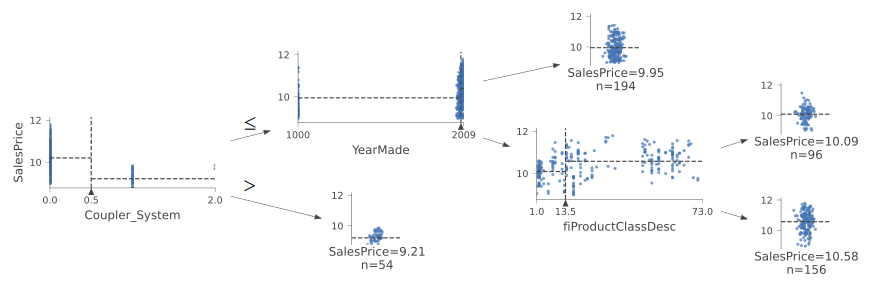

In [14]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(model, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'SalesPrice',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

This shows a chart of the distribution of the data for each split point. We can clearly see that there's a problem with our `YearMade` data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization of the values we are interested in more difficult. So, let's replace it with 1950:

In [15]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

/Users/286329i/miniforge3/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


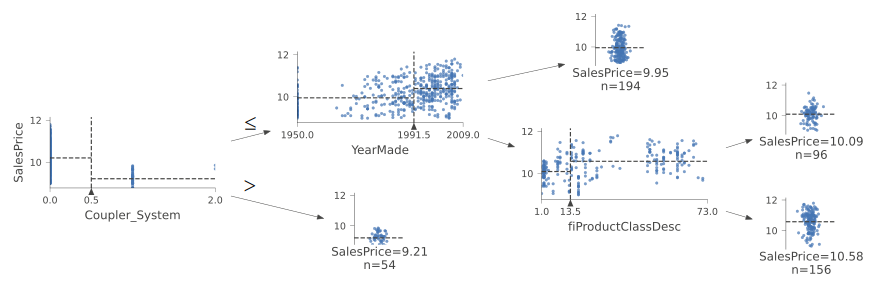

In [16]:
model = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(model, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'SalesPrice',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Let's now have the decision tree algorithm build a bigger tree. Here, we are not passing in any stopping criteria such as `max_leaf_nodes`:

In [17]:
model = DecisionTreeRegressor()
model.fit(xs, y);

We'll create a little function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:

In [18]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()),6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [19]:
m_rmse(model, xs, y)

0.0

So, our model is perfect, right? Not so fast... remember we really need to check the validation set, to ensure we're not overfitting:

In [20]:
m_rmse(model, valid_xs, valid_y)

0.334155

Oops—it looks like we might be overfitting pretty badly. Here's why:


In [21]:
model.get_n_leaves(), len(xs)

(324345, 404710)

We've got nearly as many leaf nodes as data points! That seems a little over-enthusiastic. Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 auction records:

In [22]:
model = DecisionTreeRegressor(min_samples_leaf=25)
model.fit(to.train.xs, to.train.y)
m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y)

(0.243049, 0.309541)

That looks much better. Let's check the number of leaves again:

In [23]:
model.get_n_leaves()

12432

Building a decision tree is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables. But we can see there is a fundamental compromise between how well it generalizes (which we can achieve by creating small trees) and how accurate it is on the training set (which we can achieve by using large trees).